In [2]:
pip install duckdb 

Note: you may need to restart the kernel to use updated packages.


# LOADING DATASET

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import duckdb as ddb   

# Load data
menu = pd.read_csv('../Data/manu_FC.csv')
orders = pd.read_csv('../Data/selling_transactions.csv')
inventory = pd.read_csv('../Data/inventory_waste.csv')
recipes = pd.read_csv('../Data/recipes.csv')

# Display EDA results
print("Menu DF:")
display(menu.head())
print("Orders DF:")
display(orders.head())
print("Inventory DF:")
display(inventory.head())
print("Recipes DF:")
display(recipes.head())

Menu DF:


,item_id,item_name,category,theoretical_cost,target_margin,is_active
0,ANT-001,Bruschetta al pomodoro,Antipasti,1.8,74,True
1,ANT-002,Caprese,Antipasti,2.5,72,True
2,ANT-003,Prosciutto e melone,Antipasti,3.2,71,True
3,ANT-004,Affettati misti,Antipasti,4.0,69,True
4,PIZ-001,Margherita,Pizze,2.1,77,True


Orders DF:


,transaction_id,timestamp,store_id,item_id,channel,qty,total_net_price
0,TXN-000001,2024-01-01 20:22:00,MIL-01,PIZ-002,Glovo,2,16.0
1,TXN-000002,2024-01-01 13:52:00,MIL-01,BEV-005,Sala,2,3.0
2,TXN-000003,2024-01-01 21:54:00,MIL-01,PRI-003,Deliveroo,2,26.0
3,TXN-000004,2024-01-01 20:51:00,MIL-01,SEC-005,Take-away,2,32.0
4,TXN-000005,2024-01-01 13:02:00,MIL-01,PIZ-007,Deliveroo,1,15.0


Inventory DF:


,date,store_id,item_id,ingredient_name,waste_type,waste_qty,waste_value
0,2024-01-01,MIL-01,FAR-01,Farina tipo 00 (kg),Scaduto,0.98,0.78
1,2024-01-01,MIL-01,FAR-01,Farina tipo 00 (kg),Sfrido,1.33,1.06
2,2024-01-01,MIL-01,VER-01,Verdure miste (kg),Deteriorato,1.30,4.55
3,2024-01-01,MIL-02,PRO-01,Prosciutto crudo (kg),Errore Comanda,1.92,42.24
4,2024-01-01,MIL-02,VER-01,Verdure miste (kg),Sfrido,1.85,6.48


Recipes DF:


,dish_id,dish_name,ingredient_id,ingredient_name,quantity,unit,costo_unitario,costo_ingrediente
0,ANT-001,Bruschetta al pomodoro,TOM-01,Pomodoro pelato,0.080,kg,1.2,0.10
1,ANT-001,Bruschetta al pomodoro,OLI-01,Olio EVO,0.015,lt,5.0,0.07
2,ANT-001,Bruschetta al pomodoro,BAS-01,Basilico,0.300,mazzo,1.5,0.45
3,ANT-002,Caprese,MOZZ-01,Mozzarella fior di latte,0.125,kg,5.5,0.69
4,ANT-002,Caprese,TOM-01,Pomodoro pelato,0.150,kg,1.2,0.18


### **Dfs are quite balanced in some features, so I decided augmenting data for better analysis**

In [4]:
def inject_realism_full(sales_df, inventory_df, menu_df):
    print("--- REALISTIC SIMULATION: FULL MENU ---")
    
    # Work on copies to avoid modifying original data
    sales_df = sales_df.copy()
    inventory_df = inventory_df.copy()
    
    # --- 1. SETTING SCENARIO ---
    sales_scenario = {
        'Acqua naturale':       {'qty': 4.0, 'price': 1.0},
        'Caffè':                {'qty': 3.5, 'price': 1.0},
        'Spritz':               {'qty': 2.0, 'price': 1.2},
        'Vino rosso (calice)':  {'qty': 1.5, 'price': 1.1},
        'Birra media':          {'qty': 2.5, 'price': 1.0},
        'Margherita':           {'qty': 3.0, 'price': 1.0},
        'Diavola':              {'qty': 0.6, 'price': 1.0},
        'Marinara':             {'qty': 0.2, 'price': 1.0},
        'Pizza gourmet tartufo':{'qty': 0.4, 'price': 1.5},
        'Bufala e pachino':     {'qty': 1.2, 'price': 1.2},
        'Carbonara':            {'qty': 2.2, 'price': 1.0},
        'Amatriciana':          {'qty': 1.8, 'price': 1.0},
        'Cacio e pepe':         {'qty': 1.5, 'price': 1.1},
        'Branzino al forno':    {'qty': 0.8, 'price': 1.3},
        'Tagliata di manzo':    {'qty': 0.7, 'price': 1.4},
        'Cotoletta alla milanese': {'qty': 1.5, 'price': 1.1},
        'Tiramisù':             {'qty': 2.0, 'price': 1.0},
        'Panna cotta':          {'qty': 0.5, 'price': 1.0},
    }

    waste_scenario = {
        'Mozzarella (kg)':          3.5,
        'Pesce branzino (kg)':      4.0,
        'Verdure miste (kg)':       2.5,
        'Prosciutto crudo (kg)':    1.5,
        'Carne manzo (kg)':         1.2,
        'Salame piccante (kg)':     1.8,
        'Funghi porcini (kg)':      1.3,
        'Farina tipo 00 (kg)':      0.2,
        'Olio EVO (lt)':            0.1,
        'Pomodoro San Marzano (kg)':0.3,
    }

    # --- 2. APPLYING SALES LOGIC ---
    sales_df['unit_price_temp'] = sales_df['total_net_price'] / sales_df['qty']
    
    for item_name, multipliers in sales_scenario.items():
        try:
            target_ids = menu_df.loc[menu_df['item_name'] == item_name, 'item_id'].values
            if len(target_ids) > 0:
                t_id = target_ids[0]
                mask = sales_df['item_id'] == t_id
                
                if mask.any():
                    sales_df.loc[mask, 'qty'] *= multipliers['qty']
                    new_price = sales_df.loc[mask, 'unit_price_temp'] * multipliers['price']
                    sales_df.loc[mask, 'total_net_price'] = sales_df.loc[mask, 'qty'] * new_price
        except Exception as e:
            print(f"Skipping {item_name}: {e}")

    sales_df.drop(columns=['unit_price_temp'], inplace=True)

    # --- 3. APPLYING WASTE LOGIC ---
    # Adding random noise to waste quantities
    inventory_df['waste_qty'] *= 1.0 
    
    # setting known multipliers for specific ingredients
    known_mapping = {
        'MOZZ-01': 3.5, # Mozzarella
        'PES-01':  4.0, # Branzino
        'FAR-01':  0.2, # Farina
        'SAL-01':  1.8, # Salame
        'OLI-01':  0.1, # Olio
        'TOM-01':  0.3, # Pomodoro
        'FUN-01':  1.3  # Funghi
    }
    
    for ing_id, mult in known_mapping.items():
        col_name = 'ingredient_id' if 'ingredient_id' in inventory_df.columns else 'item_id'
        mask = inventory_df[col_name] == ing_id
        
        if mask.any():
            inventory_df.loc[mask, 'waste_qty'] *= mult
            inventory_df.loc[mask, 'waste_value'] *= mult

    print("Data correctly unbalanced!")
    
    return sales_df, inventory_df

orders, inventory = inject_realism_full(orders, inventory, menu)

--- REALISTIC SIMULATION: FULL MENU ---
Data correctly unbalanced!


/var/folders/rw/gn7kmssn2p7gjvsj5rblz4sh0000gn/T/ipykernel_80876/2540362906.py:54: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[7.  7.  7.  ... 7.  7.  3.5]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  sales_df.loc[mask, 'qty'] *= multipliers['qty']


# DAYPARTING ANALYSIS

In [5]:
# -- 1. PREPARING DATA --
# Formatting timestamps in transactions
transactions = orders.copy()
transactions['time'] = pd.to_datetime(transactions['timestamp']).dt.time
transactions['date'] = pd.to_datetime(transactions['timestamp']).dt.date
transactions = transactions.drop(columns=['timestamp'])

# merging with menu table in order to have item names
transactions = pd.merge(transactions, menu[['item_id', 'item_name']], on='item_id', how='left')
transactions

,transaction_id,store_id,item_id,channel,qty,total_net_price,time,date,item_name
0,TXN-000001,MIL-01,PIZ-002,Glovo,0.4,3.20,20:22:00,2024-01-01,Marinara
1,TXN-000002,MIL-01,BEV-005,Sala,7.0,10.50,13:52:00,2024-01-01,Caffè
2,TXN-000003,MIL-01,PRI-003,Deliveroo,3.0,42.90,21:54:00,2024-01-01,Cacio e pepe
3,TXN-000004,MIL-01,SEC-005,Take-away,2.0,32.00,20:51:00,2024-01-01,Pollo arrosto
4,TXN-000005,MIL-01,PIZ-007,Deliveroo,1.2,21.60,13:02:00,2024-01-01,Bufala e pachino
...,...,...,...,...,...,...,...,...,...
159912,TXN-159913,MIL-10,PRI-003,Sala,3.0,42.90,14:21:00,2024-12-31,Cacio e pepe
159913,TXN-159914,MIL-10,DOL-001,Sala,2.0,14.00,22:57:00,2024-12-31,Tiramisù
159914,TXN-159915,MIL-10,PRI-005,Sala,1.0,16.00,22:08:00,2024-12-31,Spaghetti alle vongole
159915,TXN-159916,MIL-10,PRI-003,Take-away,1.5,21.45,13:15:00,2024-12-31,Cacio e pepe


In [6]:
# -- 2. FINDING TIME SLOTS --
# Creating new table with time slots and aggregating sales, using DuckDB
query = """select store_id, item_id, item_name, cast(sum(qty) as int) as total_sold, date, 
           case
                when time < '12:00:00' then 'Morning'
                when time >= '12:00:00' and time < '13:00:00' then 'Lunch 1'
                when time >= '13:00:00' and time < '15:00:00' then 'Lunch 2'
                when time >= '19:00:00' and time < '20:00:00' then 'Dinner 1'
                when time >= '20:00:00' and time < '22:00:00' then 'Dinner 2'
                else 'Night'
           end as time_slot
        from transactions
        group by 1,2,3,5,6,"""

# Converting to DataFrame
stats = ddb.query(query).to_df()

# Grouping by store, item, time_slot to get total sold for each time slot
stats_grouped = stats.groupby(['store_id', 'item_id', 'item_name', 'time_slot']).agg({'total_sold': 'sum'}).reset_index()
# Filtering out beverages
stats_grouped = stats_grouped[~stats_grouped['item_id'].str.contains('BEV')]

# Creating a pivot table with time slots in columns
pivot = stats_grouped.pivot_table(
    index=['item_id', 'item_name'], 
    columns='time_slot', 
    values='total_sold', 
    aggfunc='sum'
).fillna(0) 
pivot

,time_slot,Dinner 1,Dinner 2,Lunch 1,Lunch 2,Night
item_id,item_name,,,,,
ANT-001,Bruschetta al pomodoro,699,1320,1317,2444,705
ANT-002,Caprese,641,1332,1352,2597,717
ANT-003,Prosciutto e melone,697,1349,1219,2561,634
ANT-004,Affettati misti,616,1286,1284,2667,662
CON-001,Insalata mista,661,1280,1220,2593,651
CON-002,Patate al forno,599,1311,1254,2680,625
CON-003,Verdure grigliate,682,1280,1272,2633,658
DOL-001,Tiramisù,1330,2510,2444,5160,1230
DOL-002,Panna cotta,222,485,477,1098,231


In [7]:
# filtering dishes by category
entree = stats[stats['item_id'].str.contains('ANT')].drop(columns=['item_id'])
pasta = stats[stats['item_id'].str.contains('PRI')].drop(columns=['item_id'])
main_course = stats[stats['item_id'].str.contains('SEC')].drop(columns=['item_id'])
dessert = stats[stats['item_id'].str.contains('DOL')].drop(columns=['item_id'])
pizza = stats[stats['item_id'].str.contains('PIZ')].drop(columns=['item_id'])

# creating dictionary for seasonal stats
menu_dish = {'Entree' : entree, 'Pasta' : pasta, 'Main Course' : main_course,'Pizza': pizza, 'Dessert' : dessert}

<Figure size 1600x1000 with 0 Axes>

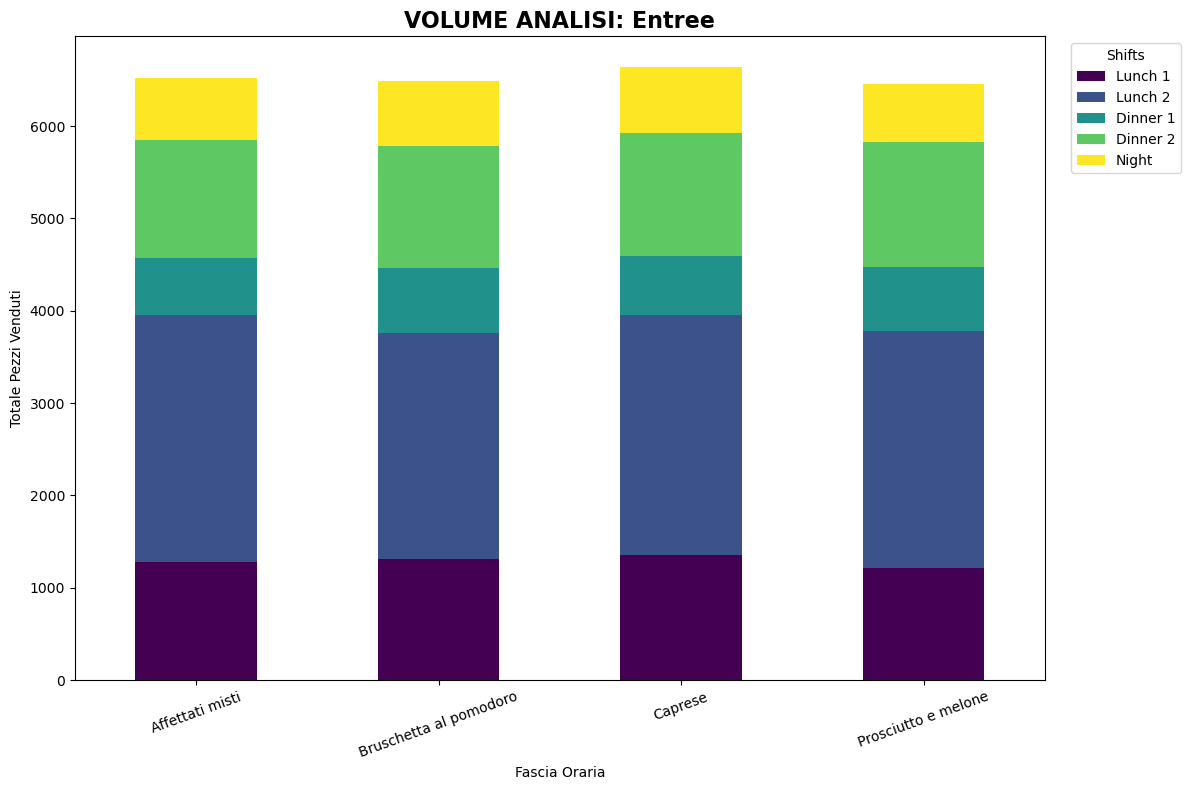

<Figure size 1600x1000 with 0 Axes>

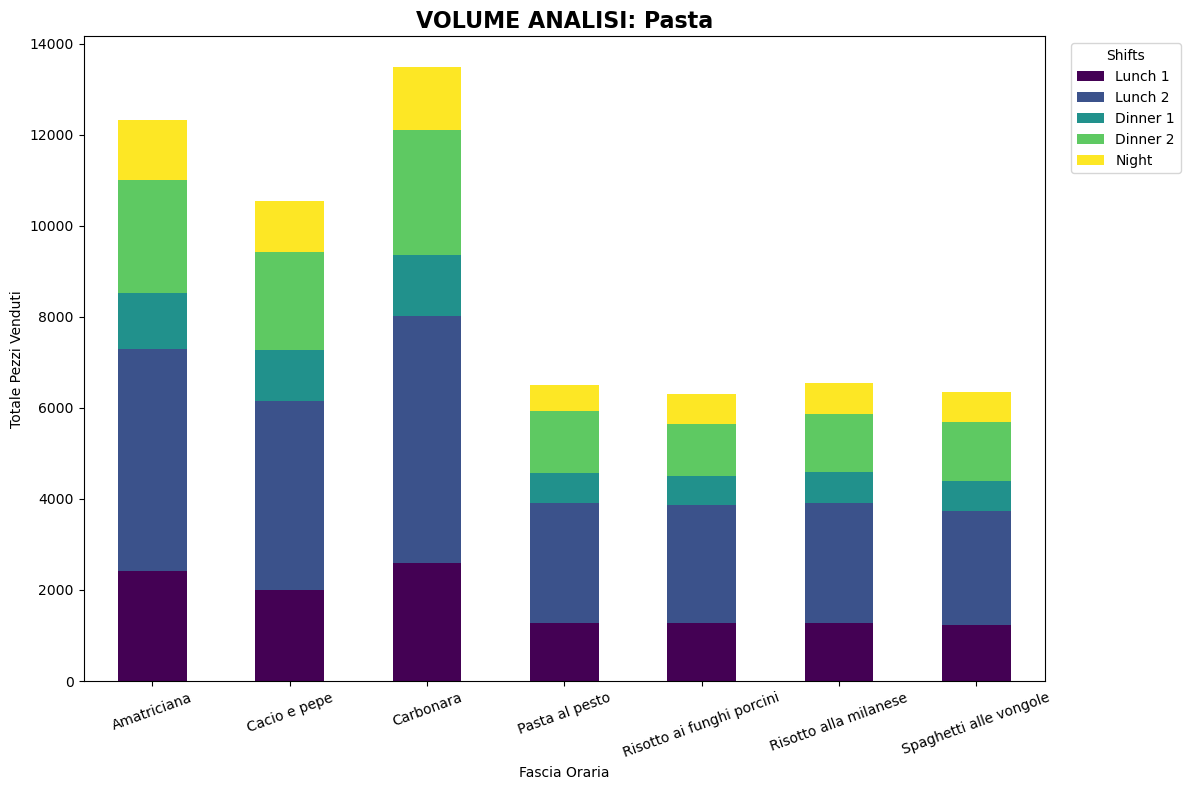

<Figure size 1600x1000 with 0 Axes>

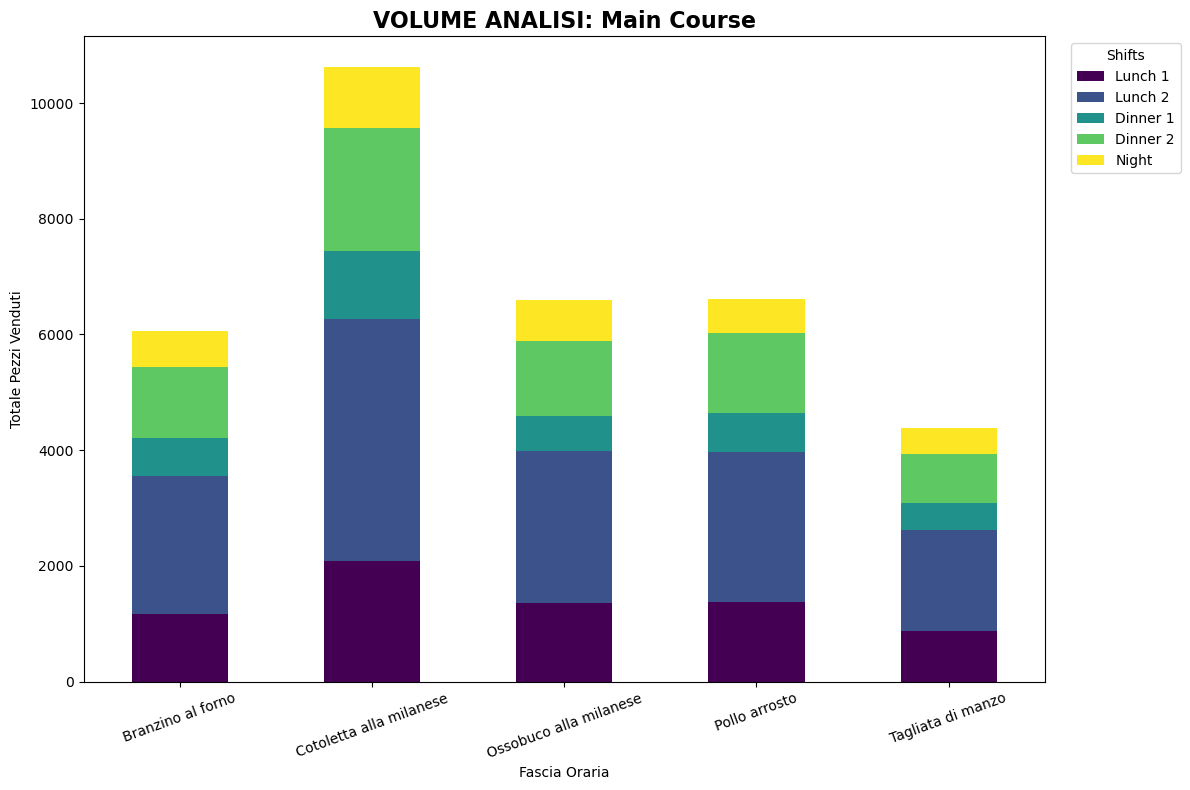

<Figure size 1600x1000 with 0 Axes>

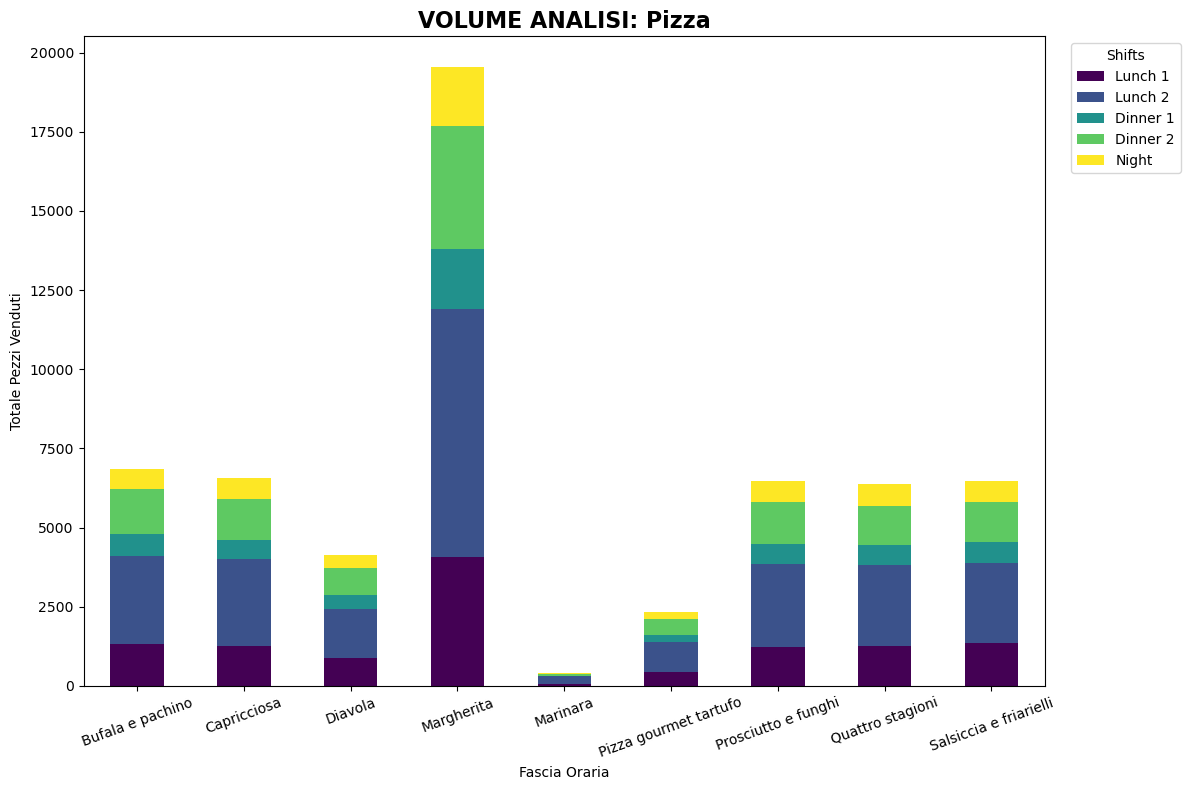

<Figure size 1600x1000 with 0 Axes>

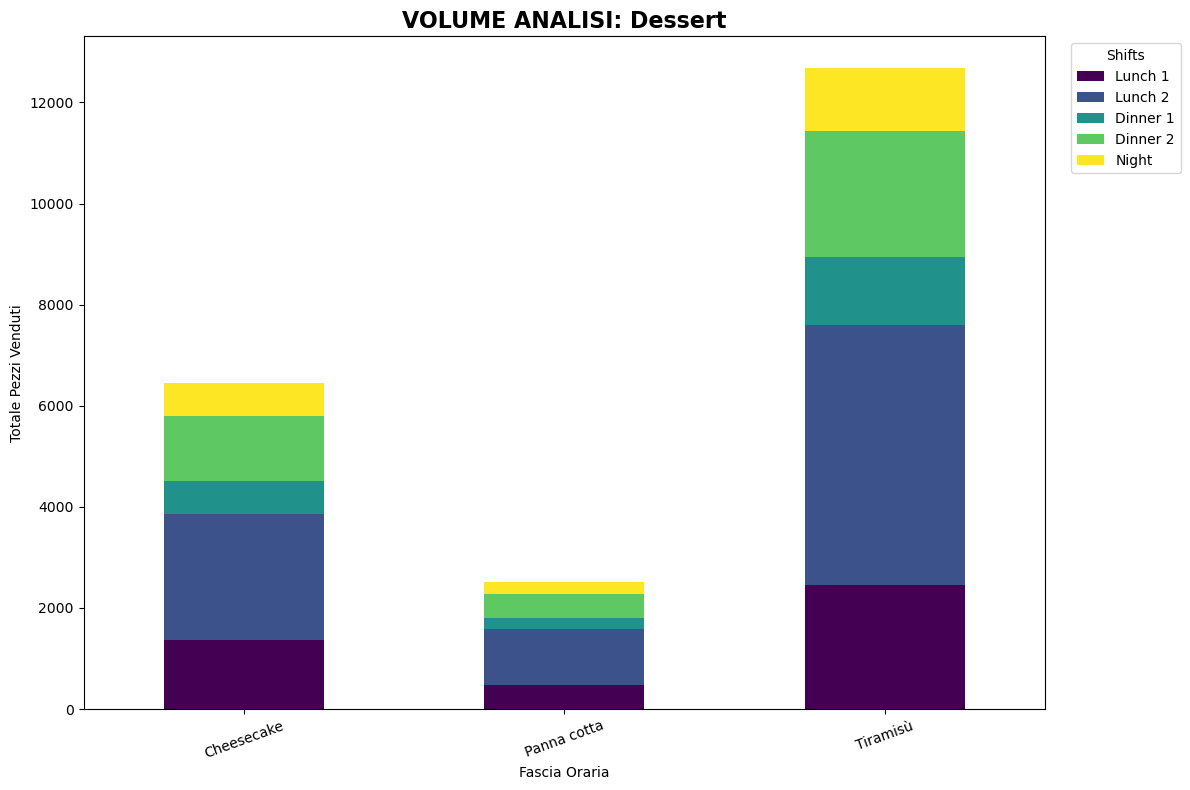

In [17]:
# -- 3. PIVOT AND PLOT FUNCTION --
def plot_pivot(df, name):
    # pivoting each category separately by time slot
    tables_shifts = ['Lunch 1', 'Lunch 2', 'Dinner 1', 'Dinner 2', 'Night']
    pivot = df.pivot_table(
    index=['item_name'], 
    columns='time_slot', 
    values='total_sold', 
    aggfunc='sum').fillna(0)
    pivot = pivot.reindex(columns=tables_shifts)
    
    # Visualizzation 
    plt.figure(figsize=(16, 10))
    ax = pivot.plot(kind='bar', stacked=True, figsize=(12, 8), colormap='viridis')
    plt.title(f'VOLUME ANALISI: {name}', fontsize=16, weight='bold')
    plt.xlabel('Fascia Oraria')
    plt.ylabel('Totale Pezzi Venduti')
    plt.xticks(rotation=20)
    plt.legend(title='Shifts', bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

for name, df in menu_dish.items():
    plot_pivot(df, name)

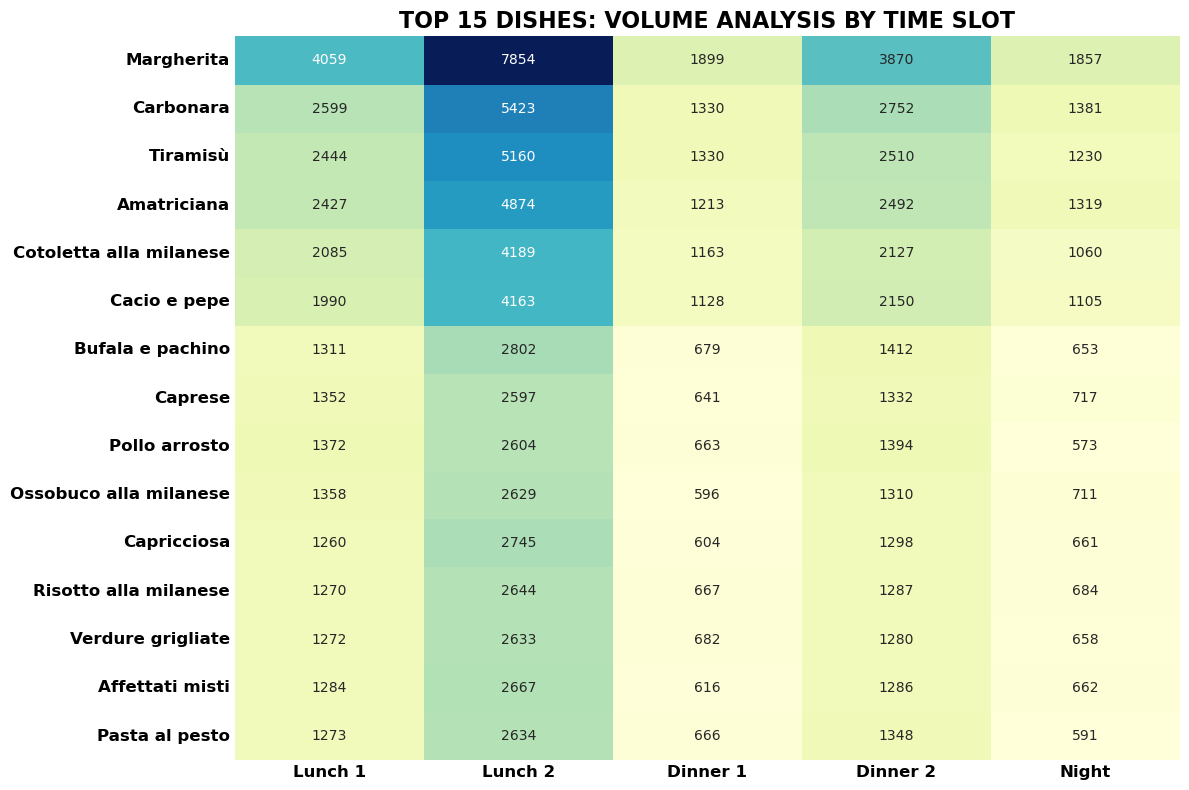

In [9]:
# -- 4. TOP 15 DISHES HEATMAP --
# heatmap for 15 most sold dishes
pivot['Total'] = pivot.sum(axis=1)
top_15 = pivot.sort_values('Total', ascending=False).drop(columns=['Total']).reset_index(level='item_id').head(15)

# Reordering columns for better visualization
tables_shifts = ['Lunch 1', 'Lunch 2', 'Dinner 1', 'Dinner 2', 'Night']
top_15 = top_15.reindex(columns=tables_shifts).rename_axis('Time Slot', axis=1).rename_axis('Item Name', axis=0)
top_15
plt.figure(figsize=(12, 8))
sns.heatmap(top_15, annot=True, fmt=".0f", cmap='YlGnBu', cbar=False)
plt.title('TOP 15 DISHES: VOLUME ANALYSIS BY TIME SLOT', fontsize=16, weight='bold')
plt.xlabel('') 
plt.ylabel('')
plt.tick_params(axis='both', which='both', length=0)
plt.xticks(fontsize=12, weight='bold')
plt.yticks(fontsize=12, weight='bold')
plt.tight_layout()
plt.show()

# SEASONALITY

In [10]:
# -- 1. SEASONALITY ANALYSIS --
# Creating new table with seasons and aggregating sales, using DuckDB
query = """select item_id, item_name, sum(qty) as total_sold, 
              case
                    when date >= '2024-04-01' and date <= '2024-06-30' then 'Spring'
                    when date >= '2024-07-01' and date <= '2024-09-30' then 'Summer'
                    when date >= '2024-10-01' and date <= '2024-12-31' then 'Autumn'
                    else 'Winter'
              end as seasons
          from transactions
          group by 1,2,4"""
seasons = ddb.query(query).to_df()

# Grouping by item and season to get total sold for each season
seasonal_stats = seasons.groupby(['item_id', 'item_name', 'seasons']).agg({'total_sold': 'sum'}).reset_index()

# Excluding beverages
seasonal_stats = seasonal_stats[~seasonal_stats['item_id'].str.contains("BEV")]

# filtering dishes by category
entree_2 = seasonal_stats[seasonal_stats['item_id'].str.contains("ANT")].drop(columns=['item_id'])
pasta_2 = seasonal_stats[seasonal_stats['item_id'].str.contains("PRI")].drop(columns=['item_id'])
main_course_2 = seasonal_stats[seasonal_stats['item_id'].str.contains("SEC")].drop(columns=['item_id'])
dessert_2 = seasonal_stats[seasonal_stats['item_id'].str.contains("DOL")].drop(columns=['item_id'])
pizza_2 = seasonal_stats[seasonal_stats['item_id'].str.contains('PIZ')].drop(columns=['item_id'])

# creating dictionary for seasonal stats
menu_dish_2 = {'Antipasti':entree_2, 'Pasta':pasta_2, 'Main': main_course_2, 'Pizza': pizza_2, 'Dessert': dessert_2}
display(menu_dish_2['Antipasti'])

,item_name,seasons,total_sold
0,Bruschetta al pomodoro,Autumn,1624.0
1,Bruschetta al pomodoro,Spring,1599.0
2,Bruschetta al pomodoro,Summer,1625.0
3,Bruschetta al pomodoro,Winter,1637.0
4,Caprese,Autumn,1687.0
5,Caprese,Spring,1692.0
6,Caprese,Summer,1617.0
7,Caprese,Winter,1643.0
8,Prosciutto e melone,Autumn,1603.0
9,Prosciutto e melone,Spring,1613.0


<Figure size 1600x1000 with 0 Axes>

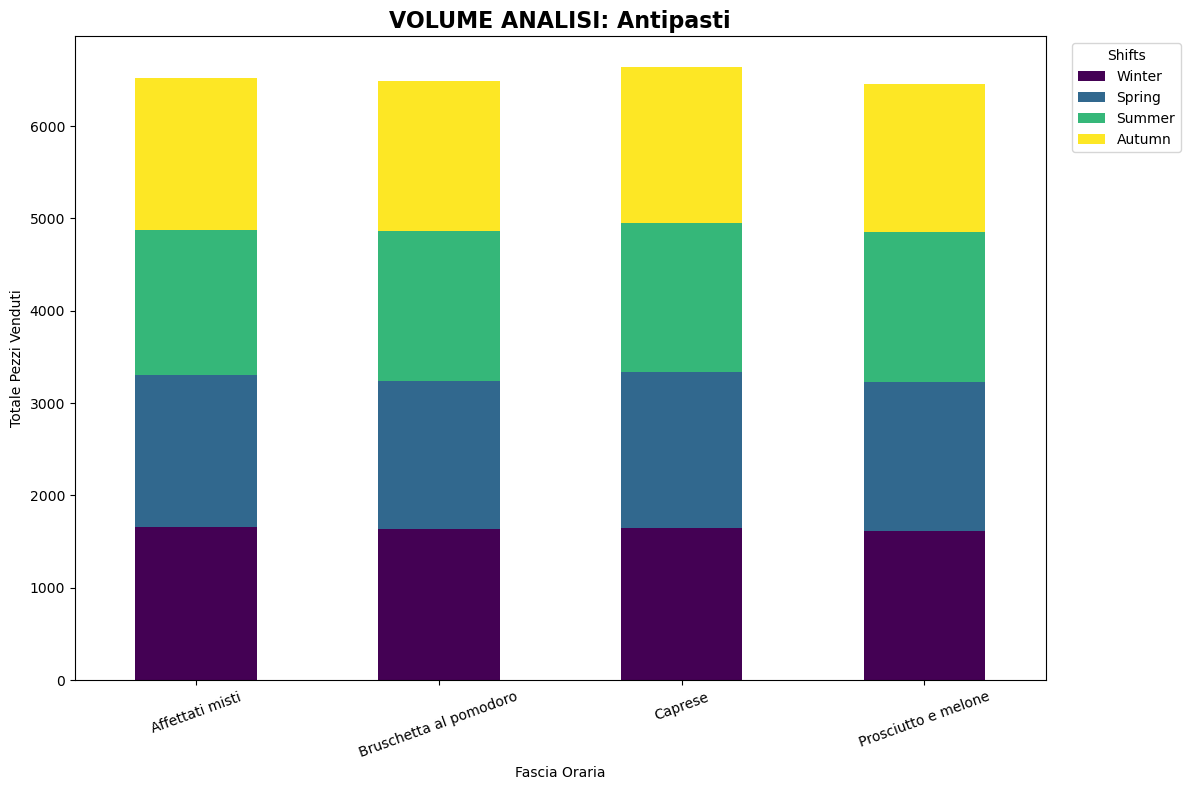

<Figure size 1600x1000 with 0 Axes>

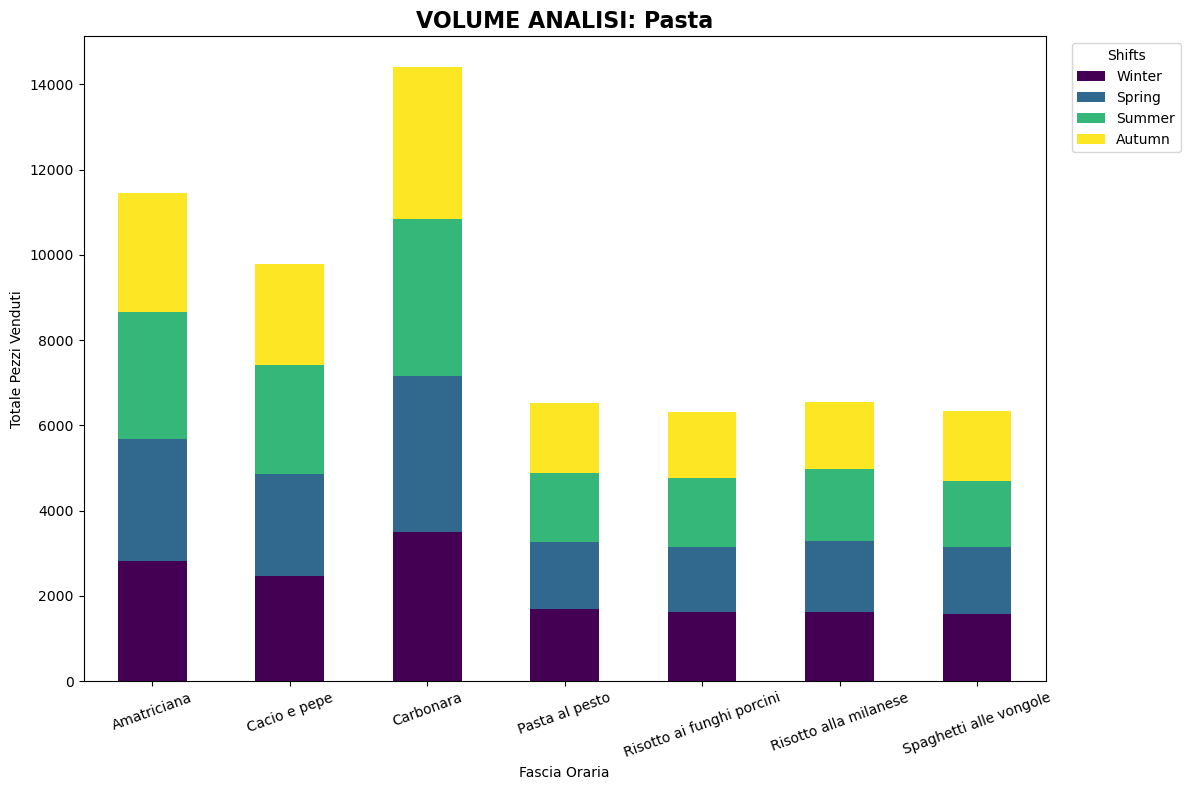

<Figure size 1600x1000 with 0 Axes>

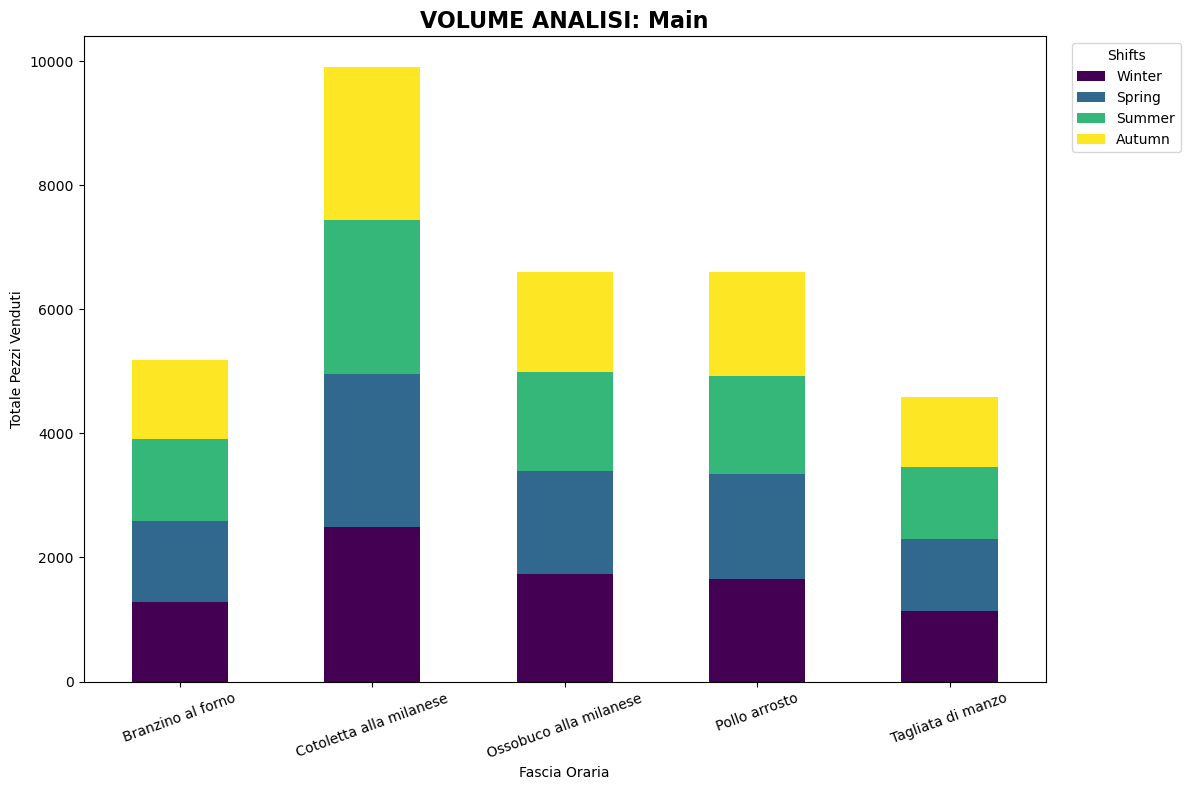

<Figure size 1600x1000 with 0 Axes>

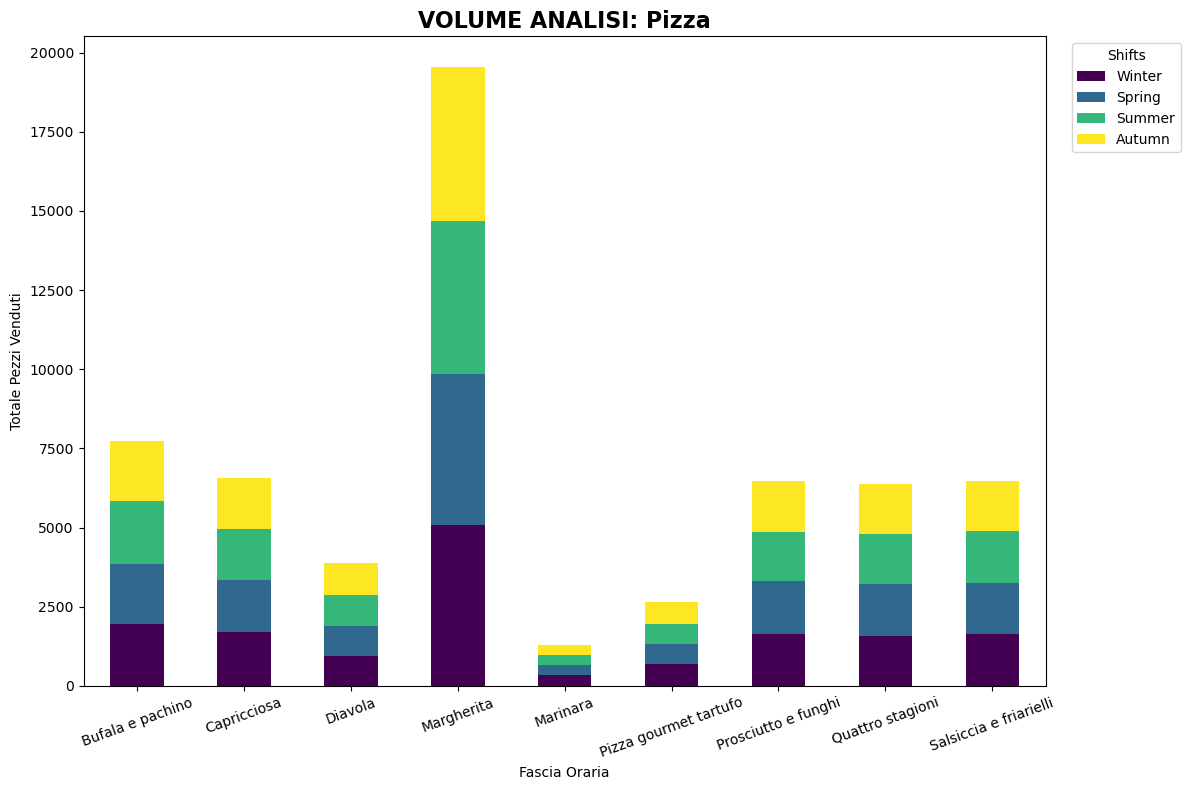

<Figure size 1600x1000 with 0 Axes>

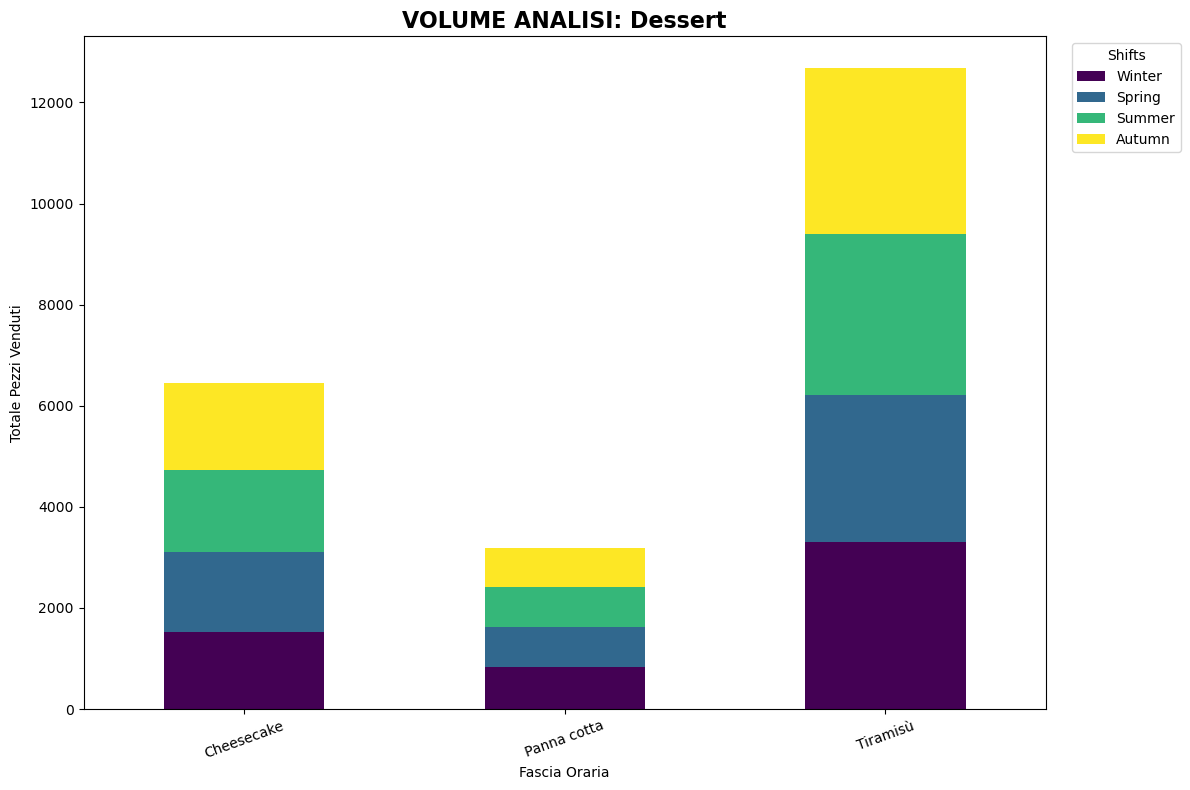

In [14]:
# -- 2. PIVOT AND PLOT FUNCTION FOR SEASONALITY --
def plot_pivot(df, name):
    seasons_cols = ['Winter', 'Spring', 'Summer', 'Autumn']
    pivot = df.pivot_table(
    index=['item_name'], 
    columns='seasons', 
    values='total_sold', 
    aggfunc='sum').fillna(0)
    pivot = pivot.reindex(columns=seasons_cols)
    
    # Visualizzation 
    plt.figure(figsize=(16, 10))
    ax = pivot.plot(kind='bar', stacked=True, figsize=(12, 8), colormap='viridis')
    plt.title(f'VOLUME ANALISI: {name}', fontsize=16, weight='bold')
    plt.xlabel('Fascia Oraria')
    plt.ylabel('Totale Pezzi Venduti')
    plt.xticks(rotation=20)
    plt.legend(title='Shifts', bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

for name, df in menu_dish_2.items():
    plot_pivot(df, name)

# SALES FORECASTING

,qty
date,
2024-01-01,805.9
2024-01-02,700.5
2024-01-03,746.9
2024-01-04,847.5
2024-01-05,724.3


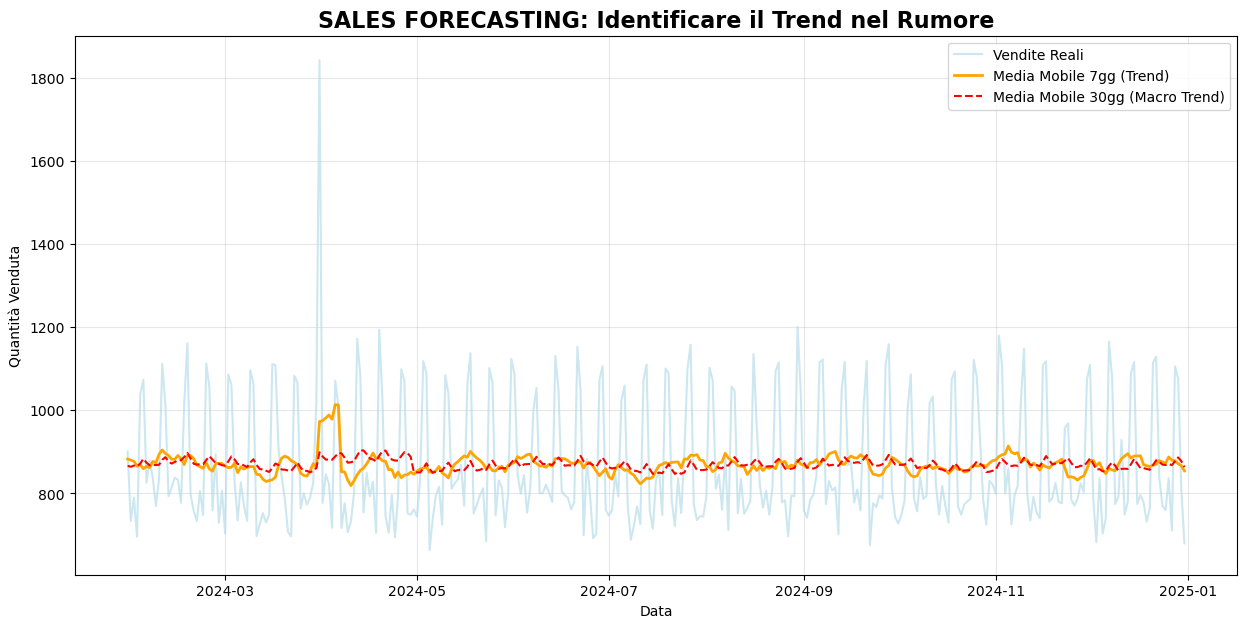

In [12]:
# -- 1.AGGREGATION BY DATE --
# Grouping all transactions by date to get the total flow
daily_sales = transactions.groupby('date')['qty'].sum().reset_index()

# -- 2. TIME INDEX SETUP --
# For historical series, the date must be the index
daily_sales = daily_sales.set_index('date').sort_index()

# showing the first rows of the daily sales
display(daily_sales.head())

# -- 3. CALCULATING MOVING AVERAGES --
# By 7 days to capture the weekly trend
daily_sales['MA_7'] = daily_sales['qty'].rolling(window=7).mean()

# By window=30 for the monthly trend
daily_sales['MA_30'] = daily_sales['qty'].rolling(window=30).mean()

# -- 4. CLEANING FROM NaN --
daily_sales = daily_sales.dropna()

# -- 5. VISUALIZATION --
plt.figure(figsize=(15, 7))

# A. Real Sales (Noisy)
sns.lineplot(data=daily_sales, x=daily_sales.index, y='qty', label='Vendite Reali', color='lightblue', alpha=0.6)

# B. Weekly Trend (Our short-term forecast)
sns.lineplot(data=daily_sales, x=daily_sales.index, y='MA_7', label='Media Mobile 7gg (Trend)', color='orange', linewidth=2)

# C. Monthly Trend (Business direction)
sns.lineplot(data=daily_sales, x=daily_sales.index, y='MA_30', label='Media Mobile 30gg (Macro Trend)', color='red', linestyle='--')

plt.title('SALES FORECASTING: Identificare il Trend nel Rumore', fontsize=16, weight='bold')
plt.xlabel('Data')
plt.ylabel('Quantità Venduta')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()